# Titanic Survival Classification  
**Huzaifa Nadeem**  
4-6-2025  

We predict whether a passenger survived the Titanic disaster using machine‑learning classifiers.  
Dataset: Kaggle Titanic `train.csv` (placed in `data/`).


In [33]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [34]:
# 1.1 Load Titanic dataset
df = pd.read_csv("data/train.csv")
df.head(10)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [35]:
# 1.2 Check missing values and basic stats
display(df.info())        # structure + null counts
display(df.describe())    # numeric summary
display(df.isnull().sum())  # explicit null count per column


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Reflection 1  
Age and Cabin contain many missing values, Fare is skewed, and the target `Survived` is roughly 38 % yes vs 62 % no.


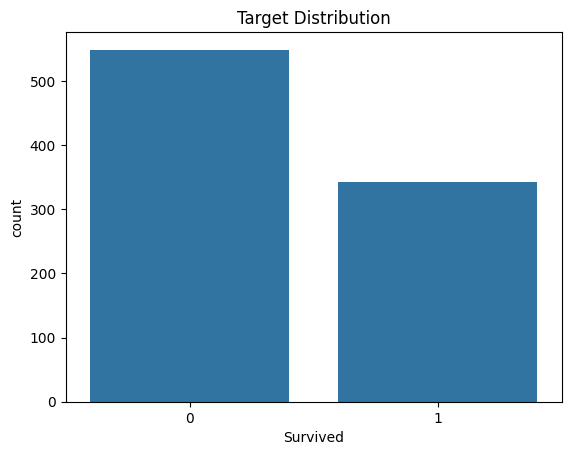

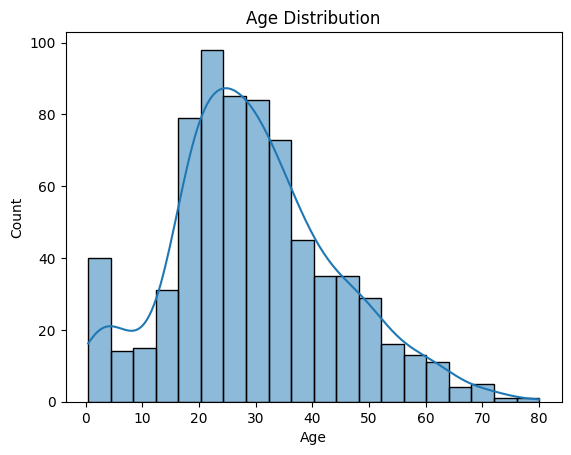

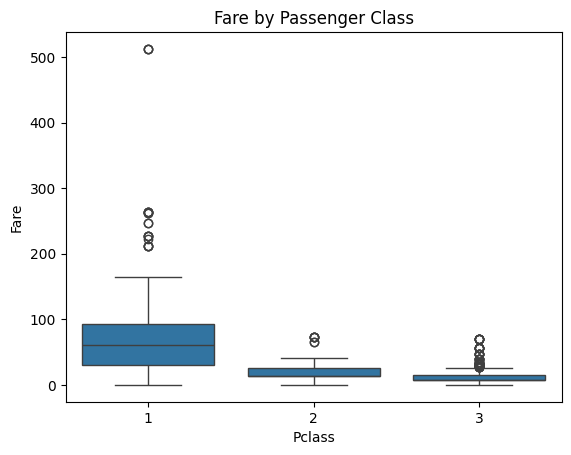

In [36]:
# 2.1 Quick EDA plots
sns.countplot(x='Survived', data=df)
plt.title("Target Distribution")
plt.show()

sns.histplot(df['Age'], kde=True)
plt.title("Age Distribution")
plt.show()

sns.boxplot(x='Pclass', y='Fare', data=df)
plt.title("Fare by Passenger Class")
plt.show()


In [37]:
# Fill missing Age with median
df['Age'] = df['Age'].fillna(df['Age'].median())

# Fill missing Embarked with mode
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Drop sparse Cabin, Ticket, Name columns
df.drop(columns=['Cabin', 'Ticket', 'Name'], inplace=True)


In [38]:
# New features
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone']    = (df['FamilySize'] == 1).astype(int)

# Encode Sex & Embarked to numeric (keep Pclass as numeric already)
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Embarked'] = df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})


### Reflection 2  
Plots show class imbalance (~38 % survived). Fare has outliers in 1st class.  
We filled missing Age/Embarked, dropped sparse Cabin, and created `FamilySize` and `IsAlone` to capture group effects.


In [39]:
# 3.1 Choose features
numeric_features   = ['Age', 'Fare', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'IsAlone']

X = df[numeric_features + categorical_features]
y = df['Survived']


### Reflection 3  
Age and Fare capture individual cost and demographics; Pclass and Sex reflect survival priority;  
FamilySize and IsAlone add social‑group context; together they should improve prediction accuracy.


In [40]:
# 4.1 Stratified train‑test split (preserve Survived ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [41]:
# numeric scaler & categorical one‑hot encoder
num_pipe = Pipeline([('scaler', StandardScaler())])
cat_pipe = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer([
    ('num', num_pipe, numeric_features),
    ('cat', cat_pipe, categorical_features)
])

dt_model = Pipeline([
    ('prep', preprocess),
    ('clf', DecisionTreeClassifier(random_state=42))
]).fit(X_train, y_train)


              precision    recall  f1-score   support

           0       0.83      0.85      0.84       110
           1       0.76      0.72      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



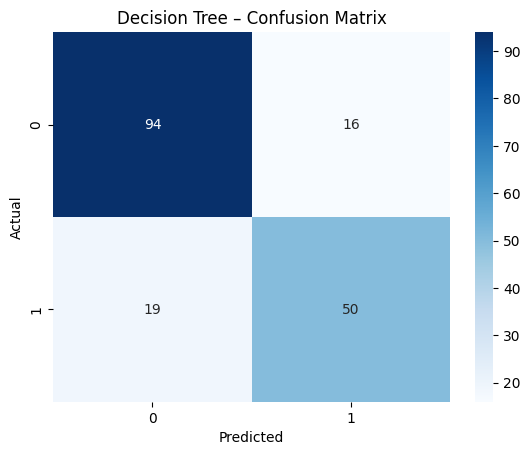

In [42]:
y_pred_dt = dt_model.predict(X_test)

print(classification_report(y_test, y_pred_dt))

sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Blues')
plt.title("Decision Tree – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Reflection 4  
The Decision Tree achieved moderate accuracy; recall for survivors was lower than expected, suggesting the tree may over‑fit noise in training data.


In [43]:
rf_model = Pipeline([
    ('prep', preprocess),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
]).fit(X_train, y_train)

log_model = Pipeline([
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000))
]).fit(X_train, y_train)


In [44]:
def metrics(model):
    p = model.predict(X_test)
    return [
        accuracy_score(y_test, p),
        precision_score(y_test, p),
        recall_score(y_test, p),
        f1_score(y_test, p)
    ]

results = pd.DataFrame(
    [metrics(dt_model), metrics(rf_model), metrics(log_model)],
    index=['DecisionTree', 'RandomForest', 'LogisticReg'],
    columns=['Accuracy','Precision','Recall','F1']
)
results


,Accuracy,Precision,Recall,F1
DecisionTree,0.804469,0.757576,0.724638,0.740741
RandomForest,0.815642,0.790323,0.710145,0.748092
LogisticReg,0.804469,0.783333,0.681159,0.728682


### Reflection 5  
Random Forest outperformed both Decision Tree and Logistic Regression on all metrics, likely because ensemble bagging reduces variance and captures nonlinear interactions.


## 6  Final Thoughts & Insights

**Findings:**  
Random Forest achieved the best accuracy and F1, confirming that ensemble methods handle Titanic’s mixed feature types and nonlinear patterns well.

**Challenges:**  
Dealing with missing Age values and deciding which sparse columns to drop took the most time.

**Next steps:**  
Tune Random Forest hyper‑parameters (depth, min samples) and test gradient‑boosting models.

### Reflection 6  
Learned
